## Proyecto Security Data Science

### Fase 2: Modelo base, Métricas personalizadas y Función optimización.

### Miembros
* Fernanda Esquivel - 21542

### Link al repositorio
El repositorio puede ser visualizado [acá](https://github.com/FerEsq/SDS-Project)

## Implementación del modelo base

In [18]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Cargar los datasets
df_train = pd.read_csv('dataset/credit_card_fraud_features_train.csv')
df_test = pd.read_csv('dataset/credit_card_fraud_features_test.csv')

In [4]:
print(f"Dataset de entrenamiento: {df_train.shape}")
print(f"Dataset de validación: {df_test.shape}")

Dataset de entrenamiento: (1571796, 75)
Dataset de validación: (280598, 75)


In [5]:
#Definir las características a usar (excluir identificadores y target)
features_to_exclude = ['is_fraud', 'cc_num', 'trans_num', 'merchant', 'first', 'last', 
                        'street', 'city', 'state', 'job', 'dob', 'trans_num', 
                        'unix_time', 'datetime', 'birth_date', 'first_tx_date',
                        'date', 'month_year']

In [6]:
#Obtener lista de características
feature_cols = [col for col in df_train.columns if col not in features_to_exclude]
print(f"\nNúmero de características a usar: {len(feature_cols)}")


Número de características a usar: 58


In [13]:
#Identificar columnas categóricas
categorical_cols = df_train[feature_cols].select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df_train[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"\nCaracterísticas categóricas encontradas: {categorical_cols}")
print(f"Características numéricas: {len(numerical_cols)}")


Características categóricas encontradas: ['category', 'gender', 'day_part', 'age_segment', 'category_simplified']
Características numéricas: 52


In [14]:
# Preparar los datos
X_train = df_train[feature_cols].copy()
y_train = df_train['is_fraud'].copy()

In [15]:
X_test = df_test[feature_cols].copy()
y_test = df_test['is_fraud'].copy()

In [19]:
#Encodificar variables categóricas
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Ajustar el encoder con todos los valores posibles (train + test)
    all_values = pd.concat([X_train[col], X_test[col]]).astype(str).unique()
    le.fit(all_values)
    
    # Transformar train y test
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    
    # Guardar el encoder
    label_encoders[col] = le

In [20]:
#Convertir booleanos a enteros
bool_cols = X_train.select_dtypes(include=['bool']).columns
for col in bool_cols:
    X_train[col] = X_train[col].astype(int)
    X_test[col] = X_test[col].astype(int)

In [21]:
print(f"\nNúmero de características a usar: {len(feature_cols)}")


Número de características a usar: 58


In [22]:
#Verificar balance de clases
print("\nBalance de clases en entrenamiento (train):")
print(y_train.value_counts(normalize=True))
print("\nBalance de clases en validación (test):")
print(y_test.value_counts(normalize=True))


Balance de clases en entrenamiento (train):
is_fraud
0    0.994401
1    0.005599
Name: proportion, dtype: float64

Balance de clases en validación (test):
is_fraud
0    0.996971
1    0.003029
Name: proportion, dtype: float64


In [ ]:
#Configurar el modelo LightGBM
#por el desbalance de clases, ajustamos algunos parametros
lgb_params = {
    'objective': 'binary',
    'metric': ['auc', 'binary_logloss'],
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'is_unbalance': True,  # Para manejar el desbalance de clases
    'random_state': 42
}

In [26]:
#Crear datasets de LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data, categorical_feature=categorical_cols)

In [27]:
#Entrenar el modelo LightGBM
model = lgb.train(
    lgb_params,
    train_data,
    valid_sets=[valid_data],
    num_boost_round=100,
    callbacks=[
        lgb.early_stopping(stopping_rounds=10),
        lgb.log_evaluation(period=10)
    ]
)

Training until validation scores don't improve for 10 rounds
[10]	valid_0's auc: 0.991437	valid_0's binary_logloss: 0.113212
[20]	valid_0's auc: 0.993101	valid_0's binary_logloss: 0.0938509
[30]	valid_0's auc: 0.994751	valid_0's binary_logloss: 0.076019
[40]	valid_0's auc: 0.99549	valid_0's binary_logloss: 0.0650967
[50]	valid_0's auc: 0.996063	valid_0's binary_logloss: 0.0557775
[60]	valid_0's auc: 0.996559	valid_0's binary_logloss: 0.0480596
[70]	valid_0's auc: 0.996997	valid_0's binary_logloss: 0.042073
[80]	valid_0's auc: 0.997332	valid_0's binary_logloss: 0.0373939
[90]	valid_0's auc: 0.997627	valid_0's binary_logloss: 0.0318982
[100]	valid_0's auc: 0.997814	valid_0's binary_logloss: 0.0282027
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.997814	valid_0's binary_logloss: 0.0282027


In [28]:
#Realizar predicciones
y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = (y_pred_proba > 0.5).astype(int)

### Métricas del modelo

In [29]:
#AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {auc_roc:.4f}")

AUC-ROC: 0.9978


In [30]:
#F1-Score
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.4f}")

F1-Score: 0.3329


In [31]:
#Precisión
precision = precision_score(y_test, y_pred)
print(f"Precisión: {precision:.4f}")

Precisión: 0.2008


In [32]:
#Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

Recall: 0.9718


In [33]:
#Average Precision (útil para datasets desbalanceados)
avg_precision = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision: {avg_precision:.4f}")

Average Precision: 0.8877


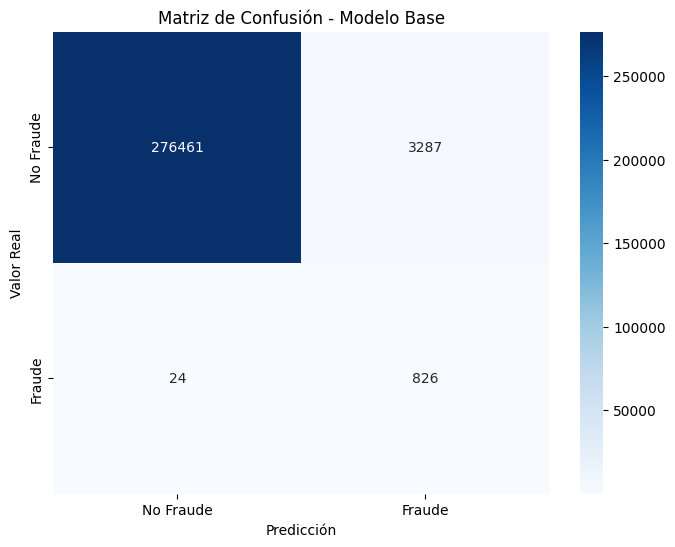

In [39]:
#Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Fraude', 'Fraude'],
            yticklabels=['No Fraude', 'Fraude'])
plt.title('Matriz de Confusión - Modelo Base')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.savefig('graphs/confusion_matrix_base_model.png', dpi=300, bbox_inches='tight')

In [40]:
#Calcular y mostrar el ratio de falsos positivos
tn, fp, fn, tp = cm.ravel()
false_positive_ratio = fp / (tp + fp) if (tp + fp) > 0 else 0
print(f"\nRatio de Falsos Positivos: {false_positive_ratio:.4f}")
print(f"Número de Fraudes Detectados: {tp}")
print(f"Número de Falsos Positivos: {fp}")
print(f"Ratio FP/TP: {fp/tp if tp > 0 else 'inf':.2f}")


Ratio de Falsos Positivos: 0.7992
Número de Fraudes Detectados: 826
Número de Falsos Positivos: 3287
Ratio FP/TP: 3.98


In [41]:
#Reporte de clasificación completo
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    279748
           1       0.20      0.97      0.33       850

    accuracy                           0.99    280598
   macro avg       0.60      0.98      0.66    280598
weighted avg       1.00      0.99      0.99    280598

